<a href="https://colab.research.google.com/github/tesseract314/DS-Unit-4-Sprint-1-Tree-Ensembles/blob/master/Lending_Club_Kaggle3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install eli5

In [2]:
!pip install category_encoders

In [3]:
!pip install mlxtend

In [0]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance

In [8]:
%%time
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import category_encoders as ce

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

X_train = pd.read_csv('train_features.csv')
X_test = pd.read_csv('test_features.csv')
y_train = pd.read_csv('train_labels.csv')['charged_off']
sample_submission = pd.read_csv('sample_submission.csv')

X_train.shape, X_test.shape, y_train.shape

CPU times: user 23.1 s, sys: 2.34 s, total: 25.5 s
Wall time: 25.9 s


In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=100000, 
    random_state=42, stratify=y_train)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((100000, 103), (1209457, 103), (100000,), (1209457,))

In [10]:
X_train.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method
48481,1266688,NaN,16000.0,16000.0,36 months,14.16%,548.09,C,C2,Teacher,6 years,RENT,54000.0,NaN,NaN,debt_consolidation,Debt consolidation,782xx,TX,32.51,3.0,Sep-2003,0.0,16.0,NaN,18.0,0.0,1689.0,60.3%,50.0,f,0.0,21.0,Individual,NaN,NaN,0.0,0.0,57829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2800.0,NaN,NaN,NaN,7.0,4131.0,64.0,92.0,0.0,0.0,127.0,120.0,6.0,6.0,0.0,29.0,NaN,15.0,16.0,0.0,2.0,4.0,4.0,13.0,24.0,9.0,25.0,4.0,18.0,0.0,0.0,2.0,2.0,88.4,100.0,0.0,0.0,70388.0,57829.0,800.0,67588.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
89588,1626342,NaN,20000.0,20000.0,60 months,11.99%,444.79,B,B5,Military Officer,7 years,MORTGAGE,95000.0,NaN,NaN,debt_consolidation,Debt consolidation,234xx,VA,24.68,0.0,Oct-2005,0.0,81.0,NaN,12.0,0.0,17825.0,40.6%,48.0,w,0.0,NaN,Individual,NaN,NaN,0.0,0.0,379392.0,0.0,5.0,0.0,1.0,14.0,50238.0,54.0,0.0,0.0,2900.0,50.0,43900.0,1.0,5.0,0.0,2.0,37939.0,0.0,100.0,0.0,0.0,145.0,116.0,28.0,14.0,2.0,87.0,NaN,14.0,NaN,0.0,1.0,4.0,1.0,1.0,33.0,6.0,13.0,4.0,12.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,456383.0,68063.0,2900.0,92475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
312829,1760098,NaN,25000.0,25000.0,36 months,15.05%,867.25,C,C4,"VP, Client Solutions",2 years,MORTGAGE,220000.0,NaN,NaN,home_improvement,Home improvement,294xx,SC,9.15,0.0,Sep-1991,0.0,50.0,NaN,8.0,0.0,20606.0,67.6%,20.0,w,0.0,50.0,Individual,NaN,NaN,0.0,0.0,243056.0,3.0,1.0,1.0,2.0,12.0,18068.0,60.0,2.0,3.0,9260.0,64.0,30500.0,3.0,1.0,4.0,6.0,30382.0,8594.0,70.6,0.0,0.0,138.0,283.0,3.0,3.0,1.0,3.0,NaN,5.0,NaN,1.0,4.0,4.0,5.0,7.0,10.0,6.0,8.0,4.0,8.0,0.0,0.0,0.0,4.0,95.0,40.0,0.0,0.0,265714.0,38674.0,29200.0,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
786545,1896150,NaN,25000.0,25000.0,36 months,16.99%,891.20,D,D1,Finance Director,10+ years,MORTGAGE,150000.0,NaN,NaN,debt_consolidation,Debt consolidation,088xx,NJ,16.86,1.0,Dec-2003,0.0,17.0,NaN,17.0,0.0,26439.0,57.9%,23.0,f,0.0,49.0,Individual,NaN,NaN,0.0,0.0,334032.0,0.0,4.0,2.0,3.0,7.0,37725.0,76.0,2.0,4.0,8343.0,67.0,45700.0,1.0,0.0,1.0,7.0,19649.0,16566.0,57.6,0.0,0.0,111.0,114.0,11.0,7.0,4.0,11.0,NaN,12.0,NaN,1.0,8.0,11.0,8.0,8.0,7.0,12.0,12.0,11.0,17.0,0.0,0.0,0.0,4.0,82.6,75.0,0.0,0.0,387353.0,64164.0,39100.0,49653.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
782178,2126770,NaN,12000.0,12000.0,36 months,6.49%,367.74,A,A2,office manager,9 years,RENT,65000.0,NaN,NaN,credit_card,Credit card refinancing,890xx,NV,25.41,0.0,Oct-20

In [11]:
X_train['installment'].skew()

1.0205481242823147

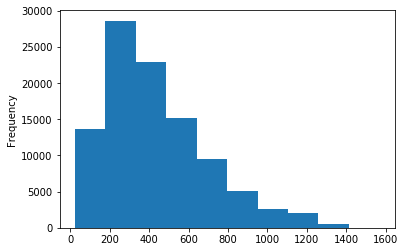

In [12]:
X_train['installment'].plot.hist()

In [13]:
%%time

def wrangle(X):
    X = X.copy()
    
    # Drop some columns
    X = X.drop(columns='id')  # id is random
    X = X.drop(columns=['member_id', 'url', 'desc'])  # All null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    
    # Transform sub_grade from "A1" - "G5" to 1.1 - 7.5
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    # Transform earliest_cr_line to an integer: how many days it's been open
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = pd.Timestamp.today() - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days
    
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    # Drop categoricals with high cardinality
    X = X.drop(columns=['emp_title', 'zip_code'])
    
    # Transform features with many nulls to binary flags
    many_nulls = ['sec_app_mths_since_last_major_derog',
                  'sec_app_revol_util',
                  'sec_app_earliest_cr_line',
                  'sec_app_mort_acc',
                  'dti_joint',
                  'sec_app_collections_12_mths_ex_med',
                  'sec_app_chargeoff_within_12_mths',
                  'sec_app_num_rev_accts',
                  'sec_app_open_act_il',
                  'sec_app_open_acc',
                  'revol_bal_joint',
                  'annual_inc_joint',
                  'sec_app_inq_last_6mths',
                  'mths_since_last_record',
                  'mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog',
                  'mths_since_recent_revol_delinq',
                  'mths_since_last_delinq',
                  'il_util',
                  'emp_length',
                  'mths_since_recent_inq',
                  'mo_sin_old_il_acct',
                  'mths_since_rcnt_il',
                  'num_tl_120dpd_2m',
                  'bc_util',
                  'percent_bc_gt_75',
                  'bc_open_to_buy',
                  'mths_since_recent_bc']

    for col in many_nulls:
        X[col] = X[col].isnull()
    
    # For features with few nulls, do mean imputation
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # Return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)
X_train.shape, X_val.shape, X_test.shape

CPU times: user 1min 2s, sys: 1.31 s, total: 1min 3s
Wall time: 1min 3s


In [62]:
X_train.head(2)

,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method,emp_title_teacher,emp_title_manager,emp_title_owner
48481,16000.0,16000.0,36 months,14.16,548.09,3.2,False,RENT,54000.0,debt_consolidation,TX,32.51,3.0,5713,0.0,False,True,18.0,0.0,1689.0,60.3,50.0,f,0.0,False,Individual,True,True,0.0,0.0,57829.0,1.045154,2.806341,0.775116,1.737331,True,35670.36531,True,1.415124,3.000988,5539.99881,58.139905,2800.0,1.086358,1.604883,2.301644,7.0,4131.0,False,False,0.0,0.0,False,120.0,6.0,6.0,0.0,False,True,False,False,0.0,2.0,4.0,4.0,13.0,24.0,9.0,25.0,4.0,18.0,False,0.0,2.0,2.0,88.4,False,0.0,0.0,70388.0,57829.0,800.0,67588.0,True,True,True,True,True,True,True,True,True,True,True,Cash,True,False,False
89588,20000.0,20000.0,60 months,11.99,444.79,2.5,False,MORTGAGE,95000.0,debt_consolidation,VA,24.68,0.0,4952,0.0,False,True,12.0,0.0,17825.0,40.6,48.0,w,0.0,True,Individual,True,True,0.0,0.0,379392.0,0.000000,5.000000,0.000000,1.000000,False,50238.00000,False,0.000000,0.000000,2900.00000,50.000000,43900.0,1.000000,5.000000,0.000000,2.0,37939.0,False,False,0.0,0.0,False,116.0,28.0,14.0,2.0,False,True,False,True,0.0,1.0,4.0,1.0,1.0,33.0,6.0,13.0,4.0,12.0,False,0.0,0.0,0.0,100.0,False,0.0,0.0,456383.0,68063.0,2900.0,92475.0,True,True,True,True,True,True,True,True,True,True,True,Cash,False,False,False


In [0]:
# test = X_train.copy()

In [67]:
# test['loan_funded_diff'] = test['loan_amnt'] == test['funded_amnt']
# test[test['loan_funded_diff'] == False]

(135, 99)

In [14]:
# no nulls
null_counts = X_train.isnull().sum()
all(null_counts == 0)

True

In [15]:
# low cardinality
cardinality = X_train.select_dtypes(exclude='number').nunique()
all(cardinality <= 50)

True

In [16]:
# Cross val with decision tree model
pipe = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=5, class_weight='balanced')
)

cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')

array([0.69172249, 0.69701752, 0.69867161, 0.69604121, 0.69877315])

In [19]:
# random forest classif with oob_score set to True

pipe = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        min_samples_leaf=0.005,
        oob_score=True,
        n_jobs=-1)
)

cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ....................... , score=0.7109404242498961, total=  18.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s


[CV] ........................ , score=0.715285214707669, total=  17.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.8s remaining:    0.0s


[CV] ....................... , score=0.7140809153032328, total=  17.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   52.8s remaining:    0.0s


[CV] ....................... , score=0.7113302857596122, total=  16.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s


[CV] ....................... , score=0.7154023813246242, total=  16.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


array([0.71094042, 0.71528521, 0.71408092, 0.71133029, 0.71540238])

In [26]:
%%time

pipe.fit(X_train, y_train)
y_pred_proba = pipe.named_steps['randomforestclassifier'].oob_decision_function_[:, 1]
print('roc_auc, out-of-bag estimate:', roc_auc_score(y_train, y_pred_proba))

roc_auc, out-of-bag estimate: 0.7122667415890263
CPU times: user 33.7 s, sys: 133 ms, total: 33.8 s
Wall time: 19.2 s


In [27]:
%%time

max_depths = list(range(2, 12, 2)) + [None]

for max_depth in max_depths:
  pipe = make_pipeline(
      ce.OrdinalEncoder(),
      RandomForestClassifier(
          n_estimators=100,
          class_weight='balanced',
          max_depth=max_depth,
          oob_score=True,
          n_jobs=-1
      )
  )
  pipe.fit(X_train, y_train)
  y_pred_proba = pipe.named_steps['randomforestclassifier'].oob_decision_function_[:, 1]
  print('max depth:', max_depth)
  print('roc_auc, oob:', roc_auc_score(y_train, y_pred_proba))

max depth: 2
roc_auc, oob: 0.6962150302607126
max depth: 4
roc_auc, oob: 0.7055122210369045
max depth: 6
roc_auc, oob: 0.7108261850767074
max depth: 8
roc_auc, oob: 0.7126247580699525
max depth: 10
roc_auc, oob: 0.7118774078455837
max depth: None
roc_auc, oob: 0.6885447910869604
CPU times: user 3min 50s, sys: 996 ms, total: 3min 51s
Wall time: 2min 8s


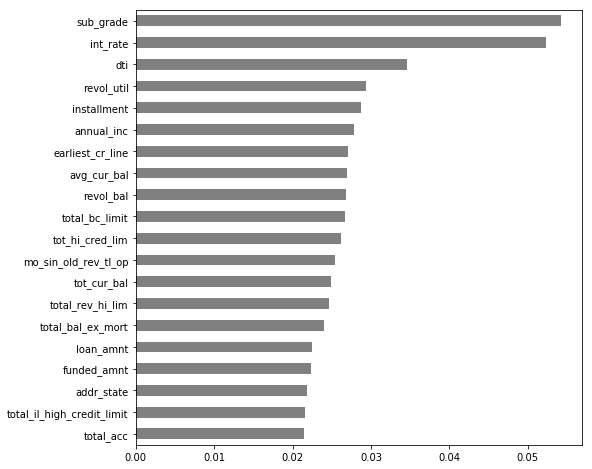

In [30]:
def show_feature_importances(pipe, X, y, estimator_name='randomforestclassifier',
                             n=20, figsize=(8, 8)):
  
  pipe.fit(X, y)
  
  importances = pd.Series(pipe.named_steps[estimator_name].feature_importances_, X.columns)
  
  top_n = importances.sort_values(ascending=False)[:n]
  
  plt.figure(figsize=figsize)
  top_n.sort_values().plot.barh(color='grey')
  
show_feature_importances(pipe, X_train, y_train)

In [31]:
# show cross val scores with dropped sub_grade feature
cross_val_score(pipe, X_train.drop(columns='sub_grade'), y_train, cv=5, scoring='roc_auc')

# Scores went down slightly

array([0.70104031, 0.70608758, 0.70475864, 0.70093389, 0.70272284])

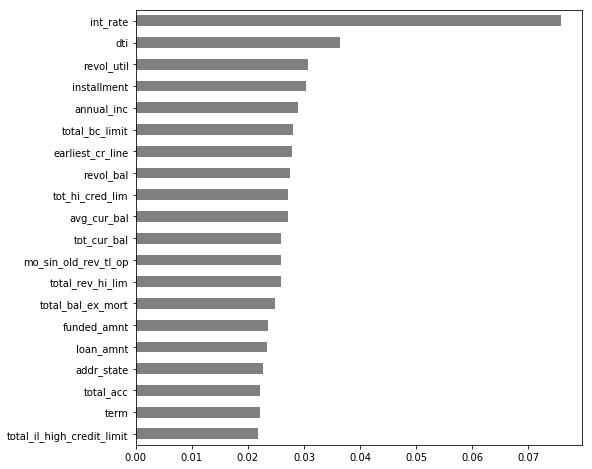

In [32]:
# show feature importances without sub_grade
show_feature_importances(pipe, X_train.drop(columns='sub_grade'), y_train)

In [34]:
# permutation importances -- do fit_transform with encoder and modeling outside pipeline

encoder = ce.OrdinalEncoder()
X_train_transformed = encoder.fit_transform(X_train)

model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    min_samples_leaf=0.005,
    n_jobs=-1)

model.fit(X_train_transformed, y_train)
permuter = PermutationImportance(model, scoring='roc_auc', n_iter=1, cv='prefit')
permuter.fit(X_train_transformed, y_train)

PermutationImportance(cv='prefit',
           estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.005,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
           n_iter=1, random_state=None, refit=True, scoring='roc_auc')

In [36]:
# visualize permutation importances

eli5.show_weights(permuter, top=None, feature_names=X_train_transformed.columns.tolist())

Weight,Feature
0.0238 ± 0.0000,sub_grade
0.0145 ± 0.0000,int_rate
0.0126 ± 0.0000,term
0.0064 ± 0.0000,dti
0.0030 ± 0.0000,acc_open_past_24mths
0.0024 ± 0.0000,avg_cur_bal
0.0021 ± 0.0000,mort_acc
0.0021 ± 0.0000,total_bc_limit
0.0020 ± 0.0000,home_ownership
0.0020 ± 0.0000,tot_hi_cred_lim


In [54]:
# make subset of data that excludes features with 0 weight

subset = X_train.columns[permuter.feature_importances_ > 0]

pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(
        n_estimators=1000,
        max_depth=None,
        min_samples_split=2,
        class_weight='balanced', 
        min_samples_leaf=0.005,
        n_jobs=-1)
)

cross_val_score(pipe, X_train[subset], y_train, cv=5, scoring='roc_auc', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ....................... , score=0.7114206727771003, total= 2.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV] ....................... , score=0.7153093335637642, total= 2.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.8min remaining:    0.0s


[CV] ....................... , score=0.7145112201122024, total= 2.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.2min remaining:    0.0s


[CV] ....................... , score=0.7120558704771413, total= 2.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.6min remaining:    0.0s


[CV] ....................... , score=0.7159091277255266, total= 2.4min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.0min finished


array([0.71142067, 0.71530933, 0.71451122, 0.71205587, 0.71590913])

In [55]:
pipe.fit(X_train, y_train)
roc_auc_score(y_val, pipe.predict_proba(X_val)[:, 1])

0.715511451428389

In [0]:
subm= sample_submission.copy() 
subm['charged_off'] = pipe.predict_proba(X_test)[:, 1] 
subm.to_csv('subm-001.csv', index=False)

98